In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,pandas,matplotlib,sklearn,seaborn

last updated: 2020-02-11 

CPython 3.7.4
IPython 7.8.0

numpy 1.16.5
pandas 0.25.1
matplotlib 3.1.1
sklearn 0.0
seaborn 0.9.0


In [2]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                 'python-machine-learning-book-2nd-edition'
                 '/master/code/ch10/housing.data.txt',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## 데이터셋의 중요 특징을 시각화하기

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

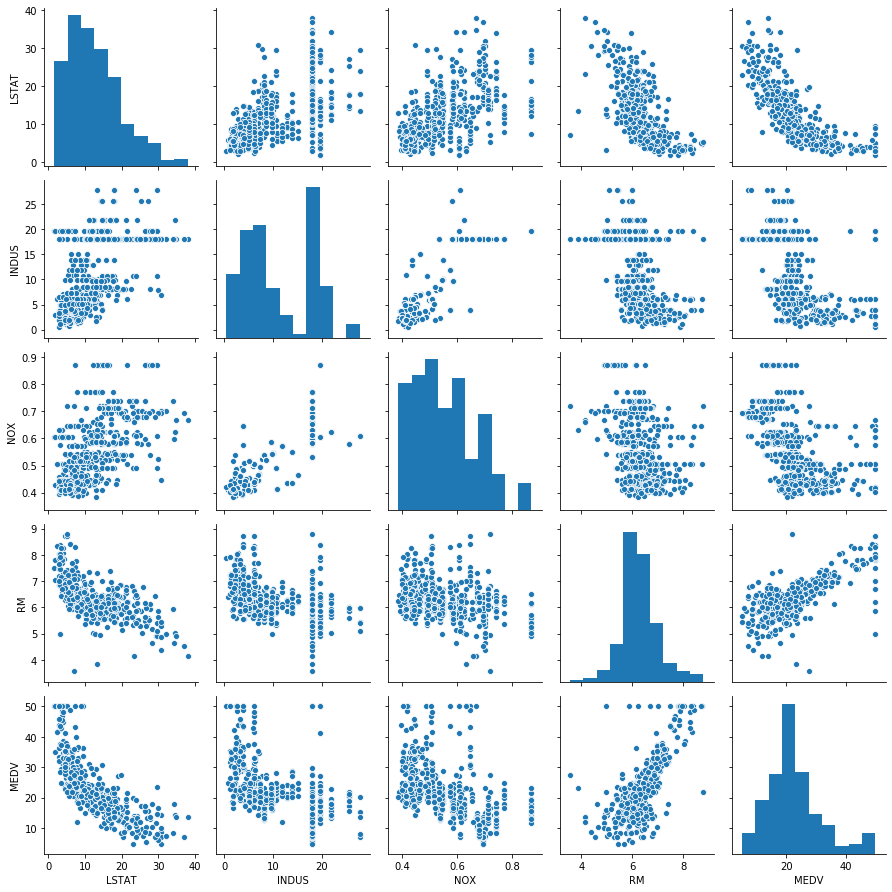

In [4]:
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']

sns.pairplot(df[cols], height=2.5)
plt.tight_layout()
plt.show()

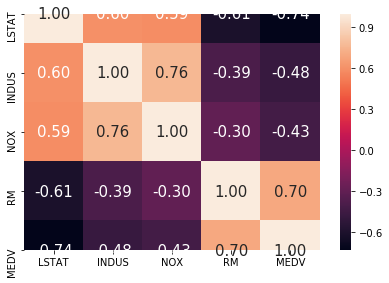

In [5]:
import numpy as np


cm = np.corrcoef(df[cols].values.T)
#sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)

plt.tight_layout()
plt.show()

# 최소 제곱 선형 회귀 모델 구현하기

## 경사 하강법으로 회귀 모델의 파라미터 구하기

In [6]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

In [7]:
X = df[['RM']].values
y = df['MEDV'].values

In [8]:
from sklearn.preprocessing import StandardScaler


sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [9]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

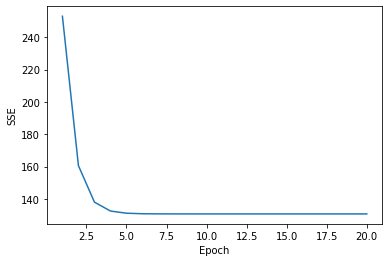

In [10]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

In [11]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)    
    return 

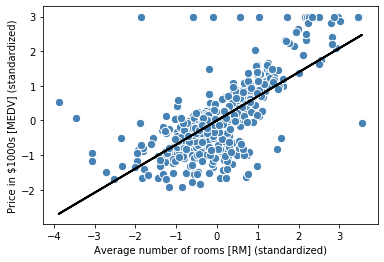

In [12]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')

plt.show()

In [13]:
print('기울기: %.3f' % lr.w_[1])
print('절편: %.3f' % lr.w_[0])

기울기: 0.695
절편: -0.000


In [14]:
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print("$1,000 단위 가격: %.3f" % sc_y.inverse_transform(price_std))

$1,000 단위 가격: 10.840


## 사이킷런으로 회귀 모델의 가중치 추정하기

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('기울기: %.3f' % slr.coef_[0])
print('절편: %.3f' % slr.intercept_)

기울기: 9.102
절편: -34.671


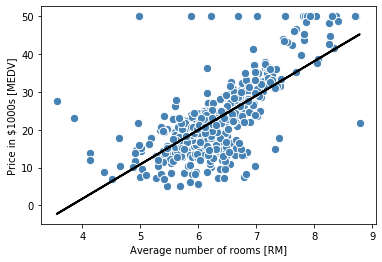

In [17]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')

plt.show()

**정규 방정식**을 사용한 방법:

In [18]:
# 1로 채워진 열 벡터 추가
Xb = np.hstack((np.ones((X.shape[0], 1)), X))
w = np.zeros(X.shape[1])
z = np.linalg.inv(np.dot(Xb.T, Xb))
w = np.dot(z, np.dot(Xb.T, y))

print('기울기: %.3f' % w[1])
print('절편: %.3f' % w[0])

기울기: 9.102
절편: -34.671


# RANSAC을 사용하여 안정된 회귀 모델 훈련하기

# ================================

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.svm import SVC

In [4]:
from sklearn.metrics import roc_curve

In [18]:
x,y = make_blobs(n_samples=1000 ,n_features=2, centers=2 , cluster_std=7)

In [19]:
x_train, x_test, y_train, y_test =train_test_split(x,y,test_size=0.3, random_state=111)

In [20]:
svc = SVC()

In [21]:
svc.fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(x_test))

In [23]:
# fpr : false positive rate (실제는 네거티브인데 포지티브라고 잘못 예측한 비율)
# tpr : true positive rate (실제 포지티브를 포지티브라고 제대로 예측한 비율)
# thresholds : 임계값 (포지티브와 네거티브를 나누는 기준값)

Text(0, 0.5, 'TPR')

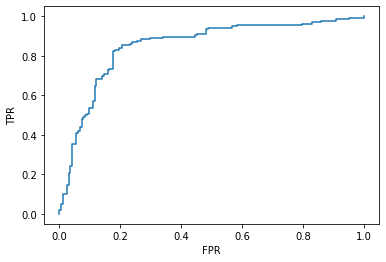

In [24]:
plt.plot(fpr, tpr, label='ROC곡선')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
rfc = RandomForestClassifier(n_estimators=500)

In [27]:
rfc.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [28]:
rf_fpr, fr_tpr, rf_thresholds = roc_curve(y_test, rfc.predict_proba(x_test)[:,1])

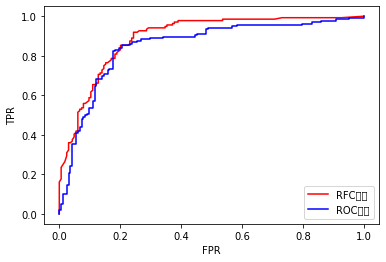

In [33]:
plt.plot(rf_fpr, fr_tpr, label='RFC곡선', c='r')
plt.plot(fpr, tpr, label='ROC곡선', c='b')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend(loc=4)

In [34]:
from sklearn.metrics import roc_auc_score
rfc_auc = roc_auc_score(y_test, rfc.predict_proba(x_test)[:,1])
svc_auc = roc_auc_score(y_test, svc.decision_function(x_test))
print('rfc의 auc :', rfc_auc)
print('svc의 auc :', svc_auc)

rfc의 auc : 0.8918355451936872
svc의 auc : 0.850161406025825


### clustering

In [51]:
X, y = make_blobs(n_samples = 150, n_features = 2, centers = 3, cluster_std=3, shuffle=True, random_state=77)

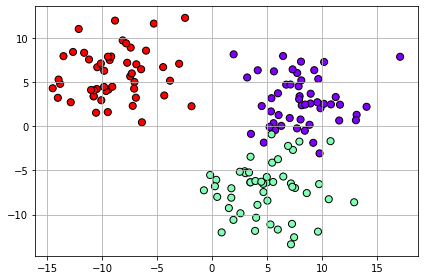

In [52]:
plt.scatter(X[:,0],X[:,1], c=y, marker='o', edgecolors='black', s=50, cmap='rainbow')
plt.grid()
plt.tight_layout()
plt.show()

In [53]:
# 1. Kmeans - center points
# 2. Hierachical
# 3. DBSCAN

In [54]:
from sklearn.cluster import KMeans

In [67]:
km= KMeans(n_clusters=3, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(X)

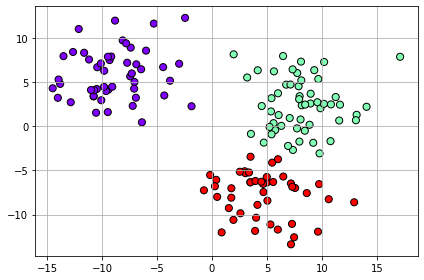

In [68]:
plt.scatter(X[:,0],X[:,1], c=y_km, marker='o', edgecolors='black', s=50, cmap='rainbow')
plt.grid()
plt.tight_layout()
plt.show()

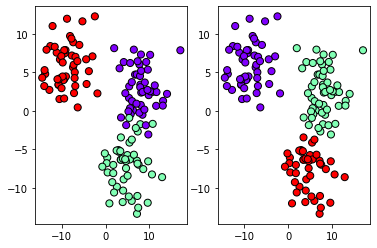

In [69]:
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.scatter(X[:,0],X[:,1], c=y, marker='o', edgecolors='black', s=50, cmap='rainbow')
ax1.scatter(X[:,0],X[:,1], c=y_km, marker='o', edgecolors='black', s=50, cmap='rainbow')

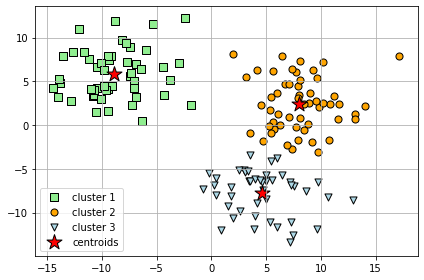

In [70]:
plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='cluster 2')
plt.scatter(X[y_km == 2, 0],
            X[y_km == 2, 1],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='cluster 3')
plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250, marker='*',
            c='red', edgecolor='black',
            label='centroids')
plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
plt.show()

## 엘보우 방법을 사용하여 최적의 클러스터 개수를 찾기

In [71]:
print('왜곡: %.2f' % km.inertia_)

왜곡: 2455.11


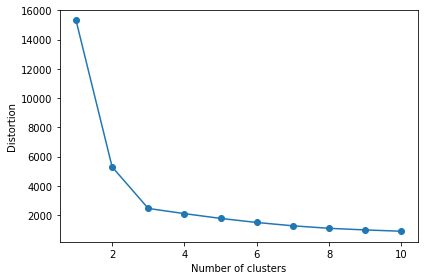

In [72]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

### silhouette

In [75]:
from sklearn.metrics import silhouette_samples
from matplotlib import cm

In [77]:
km = KMeans(n_clusters=3, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

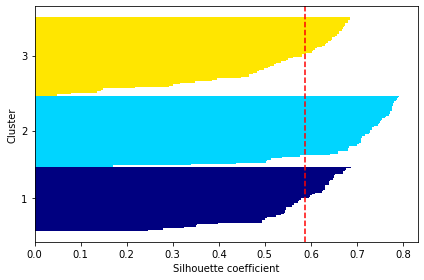

In [78]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
plt.show()

In [79]:
km = KMeans(n_clusters=2, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

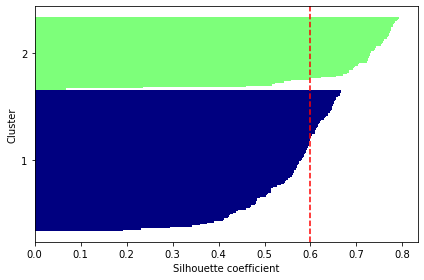

In [80]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
plt.show()

### Heirachical Clustering

In [81]:
np.random.seed(123)

variables = ['X', 'Y', 'Z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']

X = np.random.random_sample([5, 3])*10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


In [82]:
from scipy.spatial.distance import pdist, squareform
row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')),
                        columns=labels,
                        index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


In [85]:
from scipy.cluster.hierarchy import linkage

row_clusters = linkage(row_dist, method='complete', metric='euclidean')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1)
                    for i in range(row_clusters.shape[0])])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,6.521973,2.0
cluster 2,1.0,2.0,6.729603,2.0
cluster 3,3.0,5.0,8.539247,3.0
cluster 4,6.0,7.0,12.444824,5.0


In [86]:
row_clusters = linkage(pdist(df, metric='euclidean'), method='complete')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1) 
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


In [87]:
row_clusters = linkage(df.values, method='complete', metric='euclidean')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1)
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


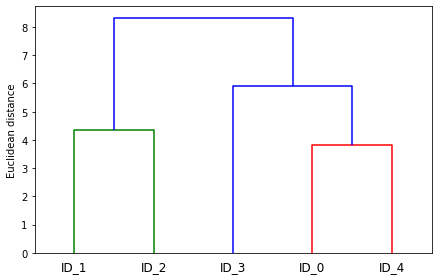

In [88]:
from scipy.cluster.hierarchy import dendrogram

# 검은색 덴드로그램 만들기 (1/2 부분만)
# from scipy.cluster.hierarchy import set_link_color_palette
# set_link_color_palette(['black'])

row_dendr = dendrogram(row_clusters, 
                       labels=labels,
                       # 검은색 덴드로그램 만들기 (2/2 부분)
                       # color_threshold=np.inf
                       )
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

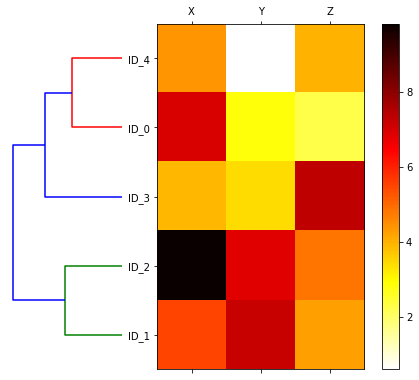

In [89]:
fig = plt.figure(figsize=(8, 8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])

# 노트: matplotlib < v1.5.1일 때는 use orientation='right'를 사용하세요
row_dendr = dendrogram(row_clusters, orientation='left')

# 군집에 맞게 데이터를 재정렬합니다.
df_rowclust = df.iloc[row_dendr['leaves'][::-1]]

axd.set_xticks([])
axd.set_yticks([])

# 덴드로그램의 축을 제거합니다.
for i in axd.spines.values():
    i.set_visible(False)

# 히트맵을 출력합니다.
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])  # x-위치, y-위치, 너비, 높이
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))

plt.show()

In [90]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=3, 
                             affinity='euclidean', 
                             linkage='complete')
labels = ac.fit_predict(X)
print('클러스터 레이블: %s' % labels)

클러스터 레이블: [1 0 0 2 1]


In [91]:
ac = AgglomerativeClustering(n_clusters=3, 
                             affinity='euclidean', 
                             linkage='complete')
labels = ac.fit_predict(X)
print('클러스터 레이블: %s' % labels)

클러스터 레이블: [1 0 0 2 1]


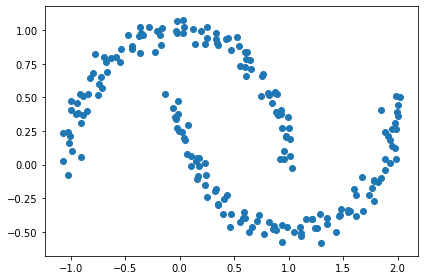

In [92]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
plt.scatter(X[:, 0], X[:, 1])
plt.tight_layout()
plt.show()

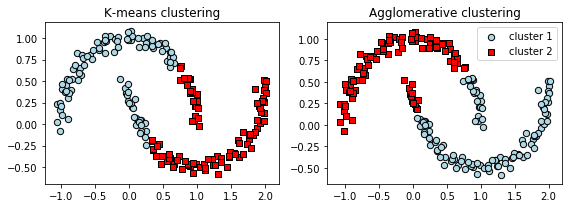

In [93]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

km = KMeans(n_clusters=2, random_state=0)
y_km = km.fit_predict(X)
ax1.scatter(X[y_km == 0, 0], X[y_km == 0, 1],
            edgecolor='black',
            c='lightblue', marker='o', s=40, label='cluster 1')
ax1.scatter(X[y_km == 1, 0], X[y_km == 1, 1],
            edgecolor='black',
            c='red', marker='s', s=40, label='cluster 2')
ax1.set_title('K-means clustering')

ac = AgglomerativeClustering(n_clusters=2,
                             affinity='euclidean',
                             linkage='complete')
y_ac = ac.fit_predict(X)
ax2.scatter(X[y_ac == 0, 0], X[y_ac == 0, 1], c='lightblue',
            edgecolor='black',
            marker='o', s=40, label='cluster 1')
ax2.scatter(X[y_ac == 1, 0], X[y_ac == 1, 1], c='red',
            edgecolor='black',
            marker='s', s=40, label='cluster 2')
ax2.set_title('Agglomerative clustering')

plt.legend()
plt.tight_layout()
plt.show()

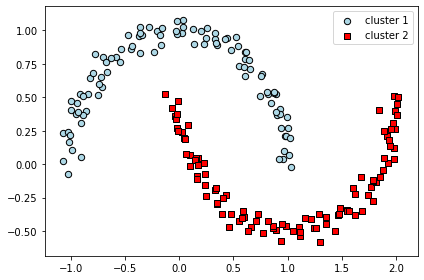

In [94]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
y_db = db.fit_predict(X)
plt.scatter(X[y_db == 0, 0], X[y_db == 0, 1],
            c='lightblue', marker='o', s=40,
            edgecolor='black', 
            label='cluster 1')
plt.scatter(X[y_db == 1, 0], X[y_db == 1, 1],
            c='red', marker='s', s=40,
            edgecolor='black', 
            label='cluster 2')
plt.legend()
plt.tight_layout()
plt.show()